In [1]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"
import numpy as np
import sympy as sp
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

import utils
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm


In [4]:
mu = 0.001 # diffusion coefficient
dt = 0.0005
tmax = 5.0
nt = int(tmax / dt)

nx = 100
ux  = 0.25

omega = np.pi

min_x, max_x = -1, 1
dx = (max_x - min_x) / nx
Cx = ux * dt / dx

In [5]:
def z(analytic_solution):
    return np.array(
    [
        analytic_solution(x) for x in np.linspace(min_x, max_x, nx)
    ],
    dtype=float
)

In [6]:
def print_domain(data, label):
    plt.figure(figsize=(6, 6))
    plt.plot(np.linspace(min_x, max_x, nx), data, label=label)
    plt.title(label)
    plt.xlabel('x')
    plt.ylabel('signal value')
    plt.grid()
    plt.savefig(f'{label}.png', dpi=300)
    plt.show()

In [7]:
# domain 1
def analytic_solution(x, t=0):
    return np.sin(omega*(x-ux*t))*np.exp(-2*mu*t*omega**2) + 1

# domain 2
def analytic_solution2(x):
    return np.exp(-((x+0.5)/0.1)**2) - np.exp(-((x-0.5)/0.1)**2) + 1

# domain 3
def analytic_solution3(x):
    return np.where((abs(x) > 0.5), 0, 2)

# domain 4
def analytic_solution4(x):
    return np.where(
        (x >= -0.6) & (x <= -0.3), 2,
        np.where((x > 0.3) & (x < 0.6), 0, 1)
    )
domains = {
    "domain 1": analytic_solution,
    "domain 2": analytic_solution2,
    "domain 3": analytic_solution3,
    "domain 4": analytic_solution4
}

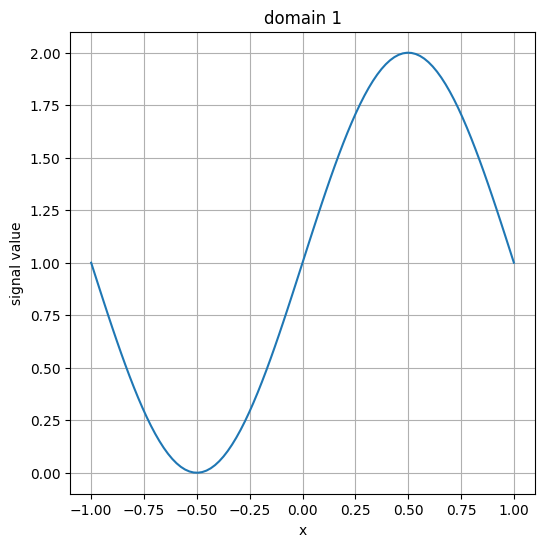

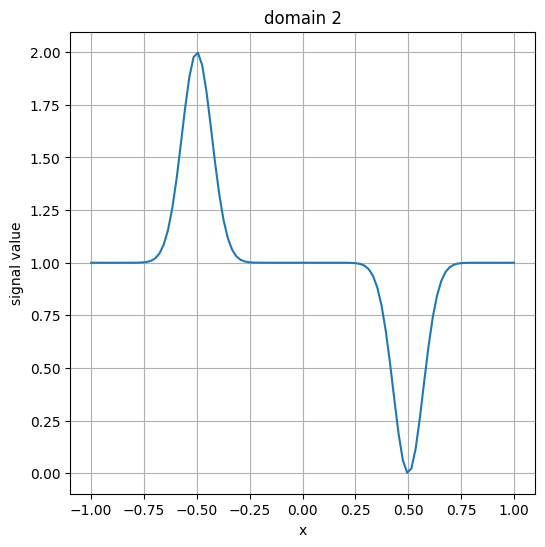

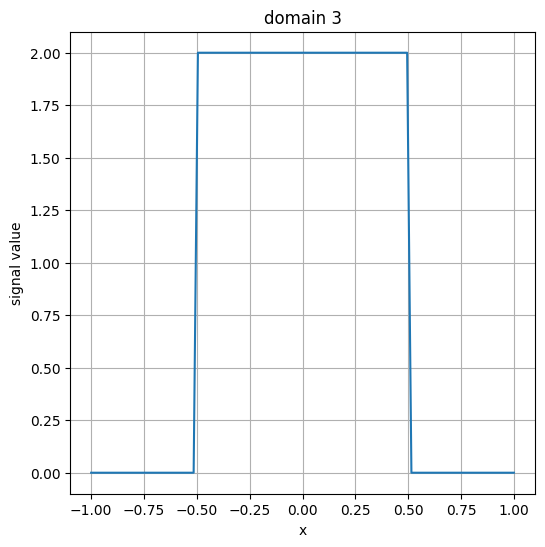

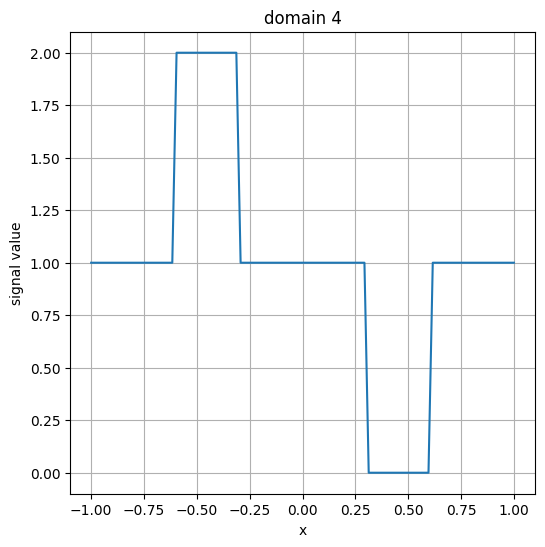

In [8]:
for label, solution in domains.items():
    u0 = z(solution)
    print_domain(u0, label)

In [2]:
train_data_dir = './data/'

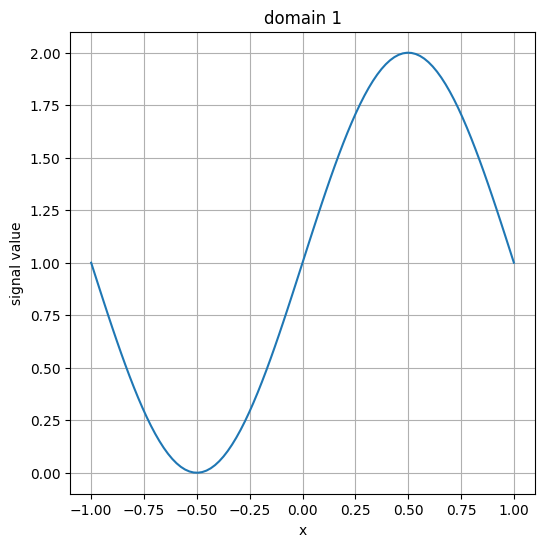

100%|██████████| 9999/9999 [00:12<00:00, 795.84it/s]


<Figure size 640x480 with 0 Axes>

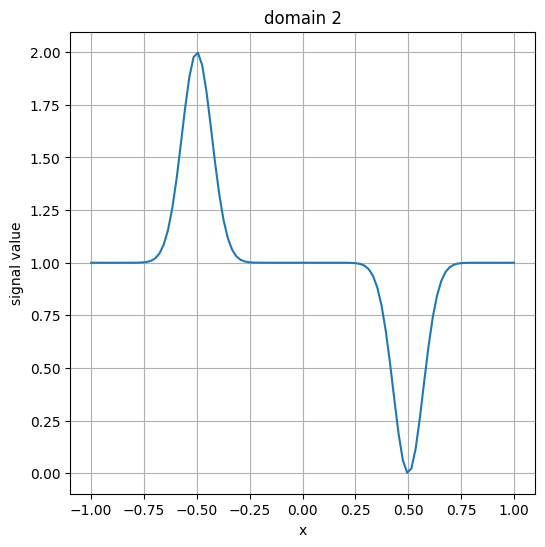

100%|██████████| 9999/9999 [00:04<00:00, 2187.82it/s]


<Figure size 640x480 with 0 Axes>

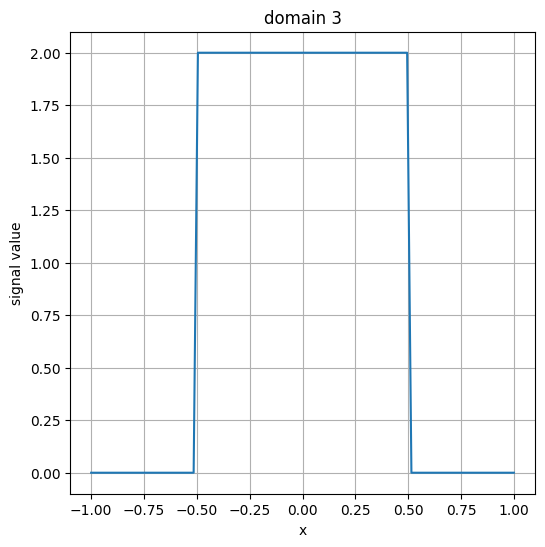

100%|██████████| 9999/9999 [00:05<00:00, 1707.80it/s]


<Figure size 640x480 with 0 Axes>

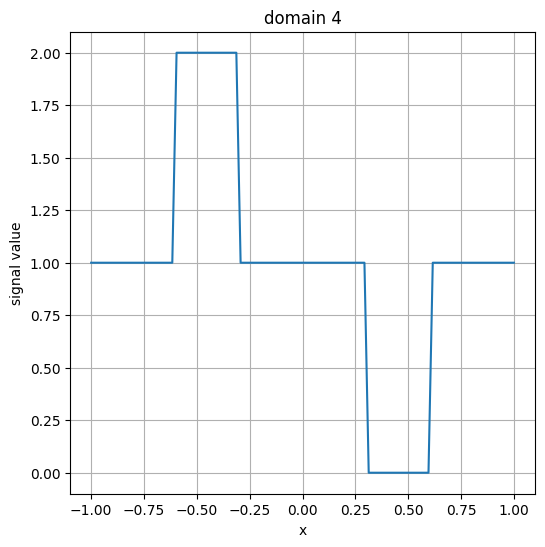

100%|██████████| 9999/9999 [00:04<00:00, 2169.93it/s]


<Figure size 640x480 with 0 Axes>

In [23]:
for label, solution in domains.items():
    u0 = z(solution)
    print_domain(u0, label)
    opts = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

    boundary_conditions = (Periodic(),)
    stepper = Stepper(options=opts, n_dims=len(u0.shape), non_unit_g_factor=False)
    solver = Solver(stepper=stepper,
                    advectee=ScalarField(u0.astype(dtype=opts.dtype), halo=opts.n_halo,
                                             boundary_conditions=boundary_conditions),
                    advector=VectorField((np.full(u0.shape[0] + 1, 0, dtype=opts.dtype),), halo=opts.n_halo,
                                             boundary_conditions=boundary_conditions)
                    )
    solver.advance(nt, mu_coeff=(mu,))
    data_full = utils.load_data(train_data_dir, nt)
    
    with open(f'data_full_{label}.pkl', 'wb') as f:
        pickle.dump(data_full, f)

In [2]:
for idx in range(1, 5):
    with open(f'data_full_domain {idx}.pkl', 'rb') as f:
        data_full = pickle.load(f)
    train_stencils, val_stencils = utils.get_stencils_2(data_full, 3, [(0, 3), (7, 10)], [(4, 6)])
    df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
    df_test = pd.DataFrame(val_stencils, columns=['input', 'flux'])
    
    # print(f"{df_train.shape=}, {df_test.shape=}")
    
    model = utils.get_model(n_hidden_layers=2, n_neurons=10)
    model, history = utils.train_model(model, df_train, df_test, epochs=5)
    model.save(f'model_domain_{idx}.h5')
    utils.visualize_output(model, df_test[:100])

train_start_1=0,train_end_1=2997, val_start_1=3996, val_end_1=5994
len(data_train)=5994, len(data_val)=1998


KeyboardInterrupt: 

train_start_1=0,train_end_1=2997, val_start_1=3996, val_end_1=5994
len(data_train)=5994, len(data_val)=1998
4/4 [==============================] - 0s 2ms/step


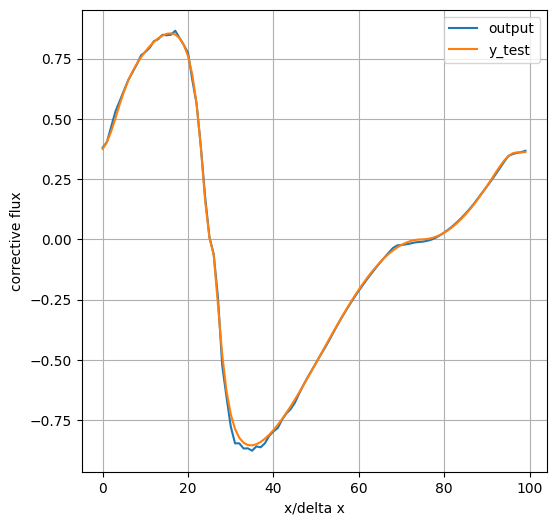

4/4 [==============================] - 0s 2ms/step


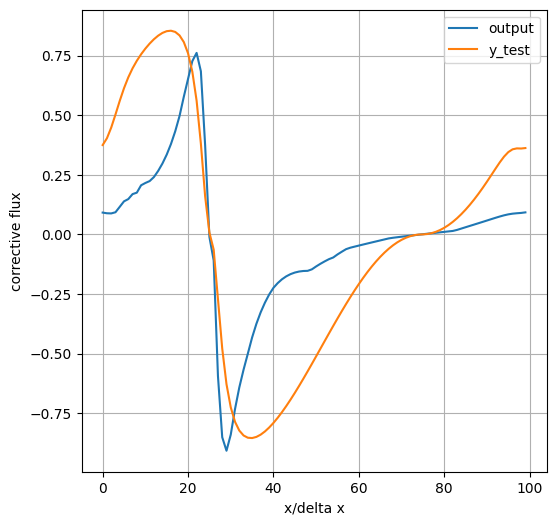

4/4 [==============================] - 0s 2ms/step


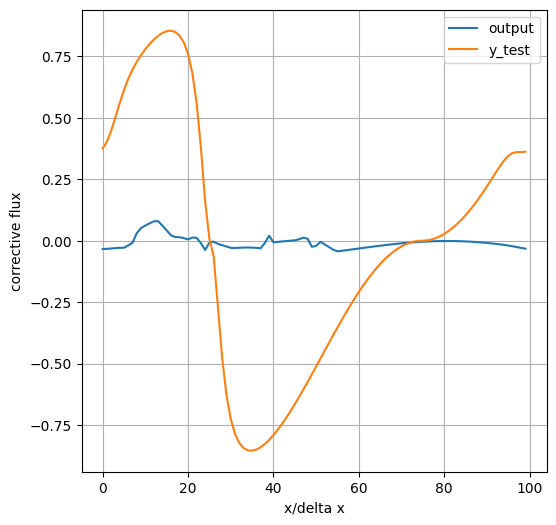

4/4 [==============================] - 0s 2ms/step


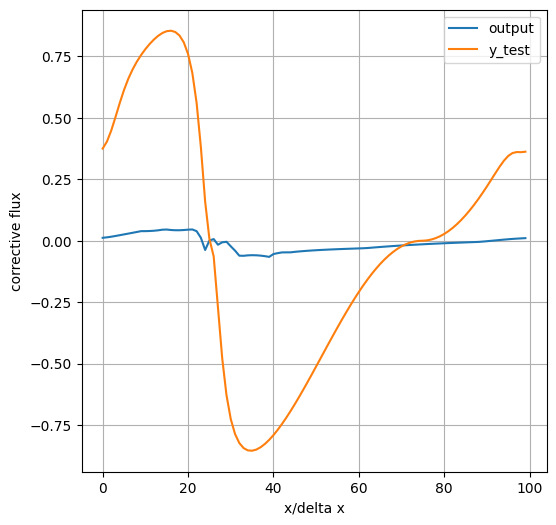

train_start_1=0,train_end_1=2997, val_start_1=3996, val_end_1=5994
len(data_train)=5994, len(data_val)=1998
4/4 [==============================] - 0s 3ms/step


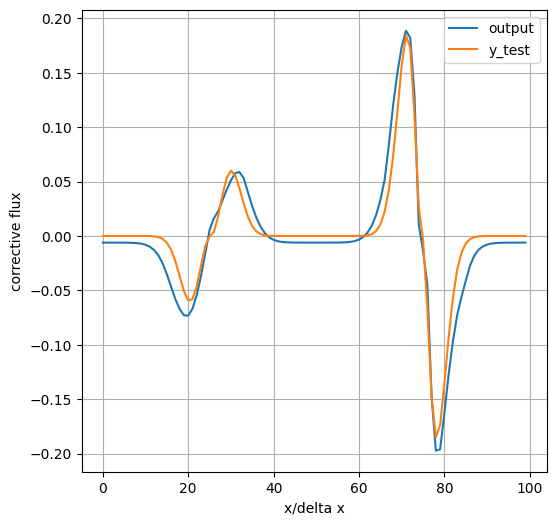

4/4 [==============================] - 0s 2ms/step


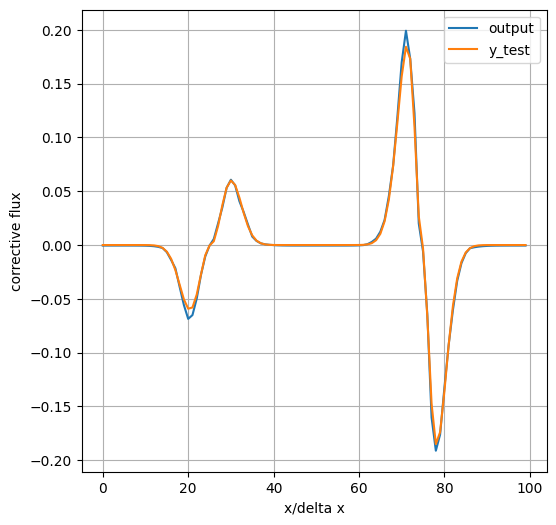

4/4 [==============================] - 0s 2ms/step


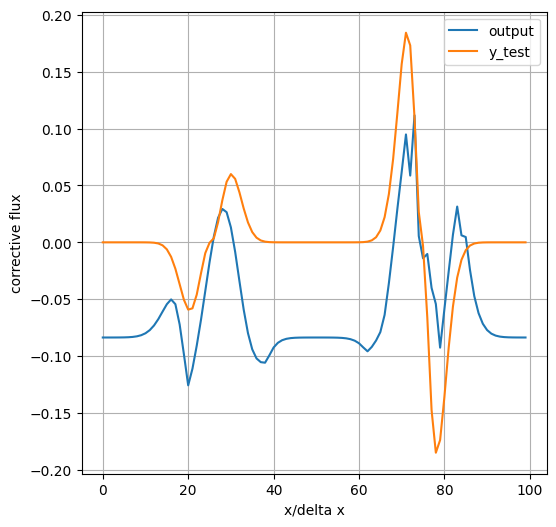

4/4 [==============================] - 0s 2ms/step


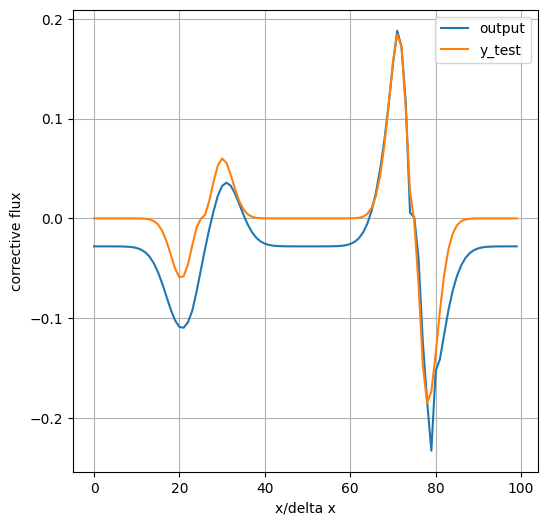

train_start_1=0,train_end_1=2997, val_start_1=3996, val_end_1=5994
len(data_train)=5994, len(data_val)=1998
4/4 [==============================] - 0s 2ms/step


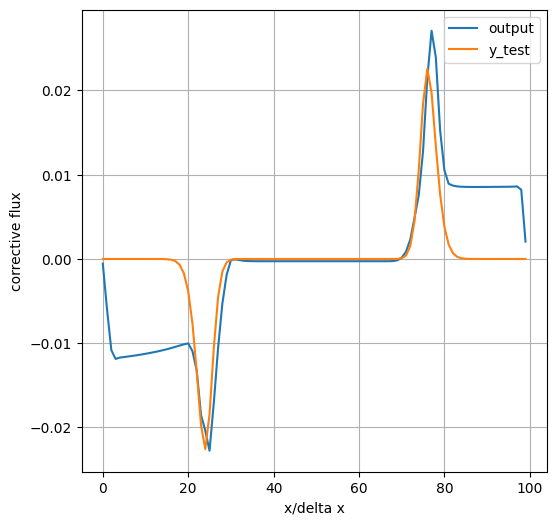

4/4 [==============================] - 0s 2ms/step


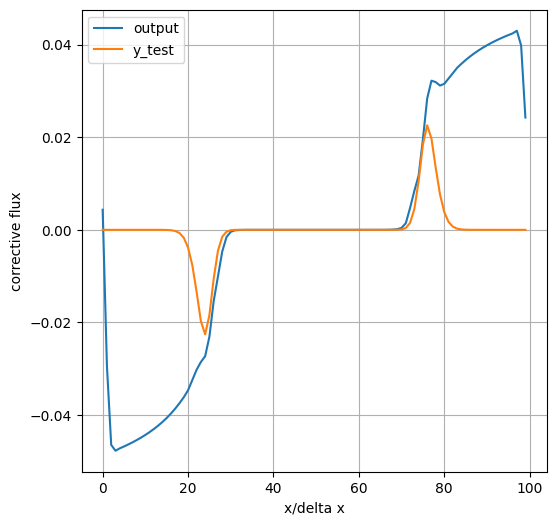

4/4 [==============================] - 0s 3ms/step


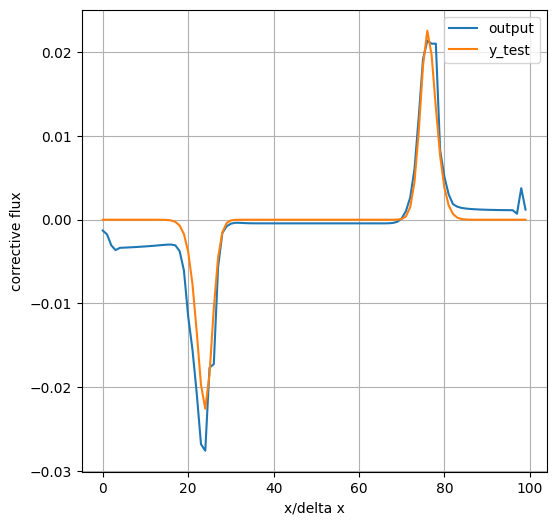

4/4 [==============================] - 0s 2ms/step


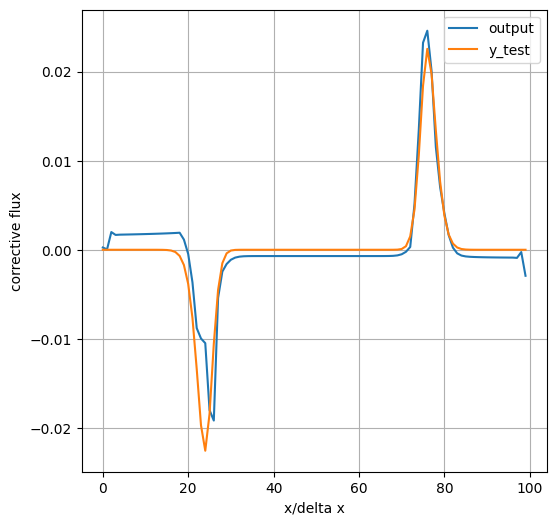

train_start_1=0,train_end_1=2997, val_start_1=3996, val_end_1=5994
len(data_train)=5994, len(data_val)=1998
4/4 [==============================] - 0s 2ms/step


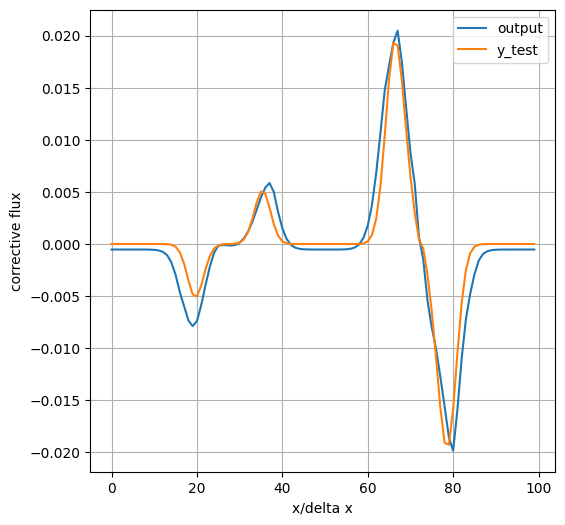

4/4 [==============================] - 0s 3ms/step


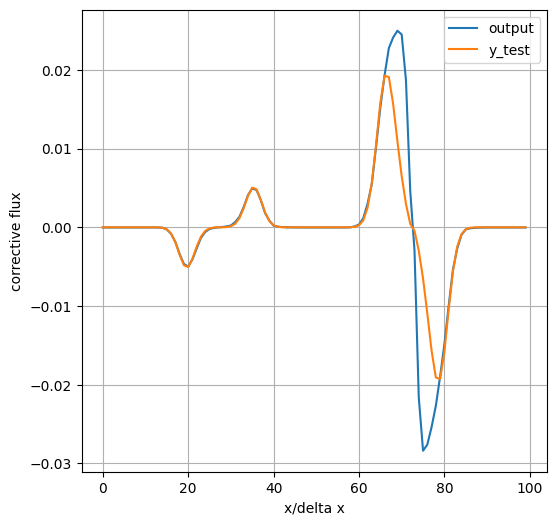

4/4 [==============================] - 0s 2ms/step


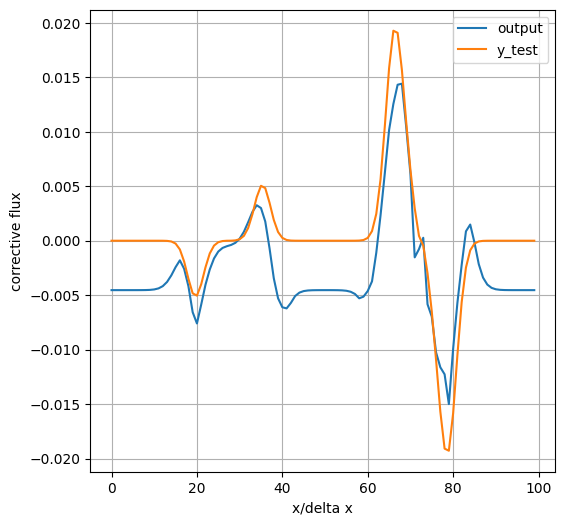

4/4 [==============================] - 0s 2ms/step


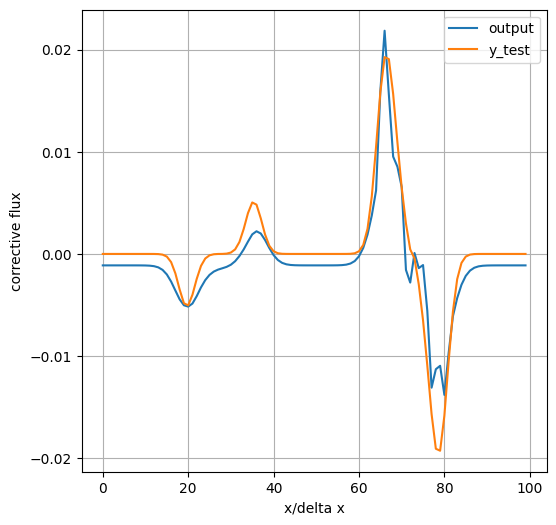

In [3]:
scaling_factors = {
    "domain 1": [1, 3, 10, 10],
    "domain 2": [0.15, 1, 22, 25],
    "domain 3": [0.015, 0.05, 1, 0.5],
    "domain 4": [0.013, 0.05, 1.2, 1]
}
for data_idx in range(1, 5):
    with open(f'data_full_domain {data_idx}.pkl', 'rb') as f:
        data_full = pickle.load(f)
    train_stencils, val_stencils = utils.get_stencils_2(data_full, 3, [(0, 3), (7, 10)], [(4, 6)])
    df_train = pd.DataFrame(train_stencils, columns=['input', 'flux'])
    df_test = pd.DataFrame(val_stencils, columns=['input', 'flux'])
    for model_idx in range(1, 5):
        model = keras.models.load_model(f'model_domain_{model_idx}.h5')
        utils.visualize_output(model, df_test[:100], scaling_factor=scaling_factors[f'domain {data_idx}'][model_idx-1], label=f"Domain {data_idx} - Model {model_idx}")